In [85]:
import pandas as pd
import numpy as np
from pymysql import connect
import os
import sys 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm



# Obtener la dirección del directorio actual
current_dir = os.getcwd()

# Obtener la dirección del directorio padre
parent_dir = os.path.dirname(current_dir)

#Creamos direccion a la carpeta de credenciales
path_credenciales = os.path.join(parent_dir,'Credenciales_folder')

#Añadimos a las direcciones el path de las credenciales
sys.path.append(path_credenciales)

from credenciales_bdd import Credenciales


 
dwh_economico = Credenciales('dwh_economico')



In [76]:
#Conexion al DWH ECONOMICO
conn_dwh = connect(user=dwh_economico.user,password=dwh_economico.password,database=dwh_economico.database,
               host=dwh_economico.host)
cursor_dwh = conn_dwh.cursor()

In [77]:
df_deflactado = pd.read_sql('SELECT * FROM supermercado_deflactado',conn_dwh)
df_deflactado

/tmp/ipykernel_12672/3779974526.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_deflactado = pd.read_sql('SELECT * FROM supermercado_deflactado',conn_dwh)


,fecha,id_region_indec,id_provincia_indec,total_facturacion,bebidas,almacen,panaderia,lacteos,carnes,verduleria_fruteria,alimentos_preparados_rostiseria,articulos_limpieza_perfumeria,indumentaria_calzado_textiles_hogar,electronica_hogar,otros
0,2017-01-01,2,6,6.278642e+06,847931.856657,1.353655e+06,226734.766263,706111.962222,469392.019866,177662.631746,91038.477409,993618.382735,193155.296873,519954.247619,700232.267330
1,2017-02-01,2,6,5.778643e+06,813672.439215,1.345861e+06,226148.377153,691166.930547,488108.622824,172801.025848,89127.789805,902511.136277,151197.719689,369253.083312,586157.562242
2,2017-03-01,2,6,6.045451e+06,801837.490175,1.511483e+06,251260.379741,748838.241312,516708.733158,172686.040993,94211.449652,959431.655238,139070.199331,356051.503867,541963.761508
3,2017-04-01,2,6,6.341997e+06,767654.809282,1.685587e+06,285611.550643,737310.462677,567468.542118,165538.828042,97638.374621,977918.914405,187352.716059,442885.131821,505866.208270
4,2017-05-01,2,6,5.962564e+06,669492.516680,1.556599e+06,247883.461304,707910.295541,503281.362912,154113.417066,87076.984080,916544.922092,204087.031264,501471.369568,483930.490211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2170,2023-11-01,7,94,3.277681e+05,37778.263389,8.609735e+04,6103.644576,17963.795564,33747.947523,39218.441860,NaN,41355.691029,11420.021896,NaN,22698.252649
2171,2023-12-01,7,94,3.965303e+05,55213.285783,9.785393e+04,6583.235370,18790.172522,45373.185314,46179.050806,NaN,49626.794773,12366.179734,NaN,29636.465713
2172,2024-01-01,7,94,2.834070e+05,30057.733025,6.971892e+04,5208.240004,15535.927028,26880.098539,37361.526580,NaN,37390.816158,6592.090288,NaN,17850.388831
2173,2024-02-01,7,94,2.855477e+05,29166.036311,7.104059e+04,5150.040151,15566.632290,29925.202810,37966.886036,NaN,33708.858072,7170.110806,NaN,19720.138833


In [78]:
datos_nea = df_deflactado[df_deflactado['id_provincia_indec'].isin([18,22,30,34,54])]

<h1> Exploracion de datos del NEA </h1>

<hr>
Idea principal: predecir a futuro las ventas de supermercados del NEA en cada una de sus provincias
<hr>
<hr>
Herramienta principal a utilizar: bibliotecas de forecasting y regresiones lineales
<hr>
<p>Otras cuestiones:</p>
<ol>
  <li>Existe relacion con CBA y CBT?</li>
  <li>Conexion con la inflacion que presento en NEA historicamente</li>
</ol>

Observamos movimiento del total de facturacion de cada provincia

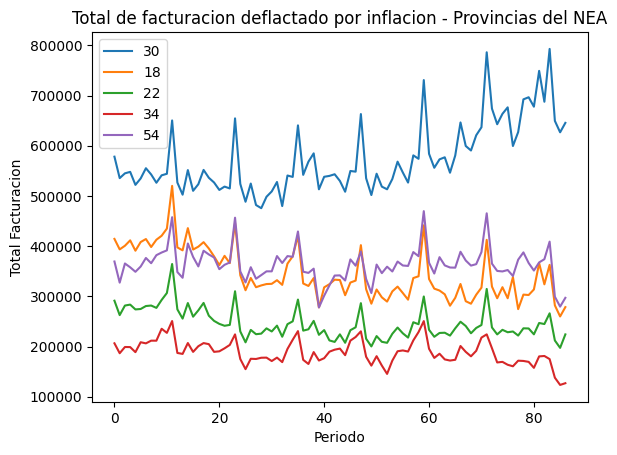

In [79]:
largo = np.arange(0,len(df_deflactado['total_facturacion'][df_deflactado['id_provincia_indec'] == 18])) 

lista_ids = datos_nea['id_provincia_indec'].unique()

for id in lista_ids:

    plt.plot(largo,df_deflactado['total_facturacion'][df_deflactado['id_provincia_indec'] == id],label = id)
    

plt.title("Total de facturacion deflactado por inflacion - Provincias del NEA")
plt.xlabel("Periodo")
plt.ylabel("Total Facturacion")
plt.legend()
plt.show()

Movimientos de las distintas ventas

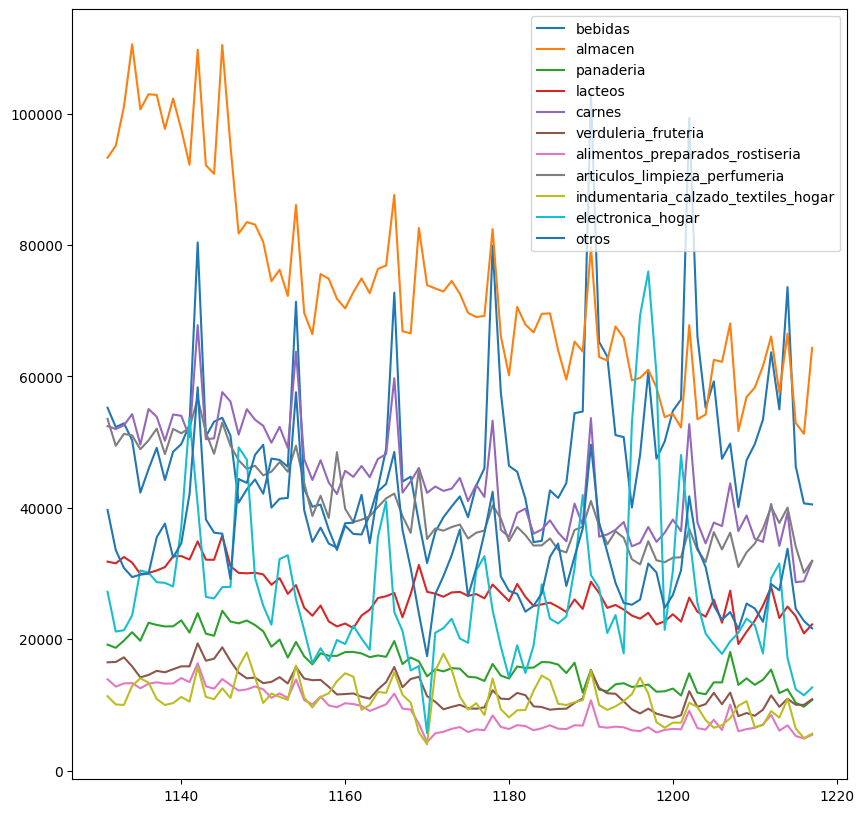

In [80]:
columnas = list(datos_nea.columns)
columnas.remove('total_facturacion')
columnas.remove('id_region_indec')
columnas.remove('id_provincia_indec')
columnas.remove('fecha')



plt.figure(figsize=(10,10))
for columna in columnas:

    id_base = 18 #--> Corrientes
    plt.plot(datos_nea[columna][datos_nea['id_provincia_indec'] == id_base],label = columna)

plt.legend()
plt.show()

Correlaccion de movimientos

In [83]:
mtz_corr = datos_nea[columnas][datos_nea['id_provincia_indec'] == id_base].corr()
mtz_corr

,bebidas,almacen,panaderia,lacteos,carnes,verduleria_fruteria,alimentos_preparados_rostiseria,articulos_limpieza_perfumeria,indumentaria_calzado_textiles_hogar,electronica_hogar,otros
bebidas,1.000000,-0.124345,0.052771,0.143978,-0.021686,-0.063376,0.116669,0.408265,-0.258525,0.127820,0.377027
almacen,-0.124345,1.000000,0.799208,0.702286,0.881301,0.862819,0.409127,0.286058,0.743379,0.183059,0.458554
panaderia,0.052771,0.799208,1.000000,0.725025,0.791607,0.753994,0.634541,0.504092,0.651878,0.384653,0.464282
lacteos,0.143978,0.702286,0.725025,1.000000,0.543253,0.600033,0.117265,0.370213,0.408630,0.384822,0.273616
carnes,-0.021686,0.881301,0.791607,0.543253,1.000000,0.838593,0.594357,0.463006,0.695754,0.192559,0.456673
verduleria_fruteria,-0.063376,0.862819,0.753994,0.600033,0.838593,1.000000,0.575644,0.393271,0.602731,0.092947,0.485766
alimentos_preparados_rostiseria,0.116669,0.409127,0.634541,0.117265,0.594357,0.575644,1.000000,0.431668,0.435367,0.266777,0.585653
articulos_limpieza_perfumeria,0.408265,0.286058,0.504092,0.370213,0.463006,0.393271,0.431668,1.000000,0.297010,0.269285,0.447921
indumentaria_calzado_textiles_hogar,-0.258525,0.743379,0.651878,0.408630,0.695754,0.602731,0.435367,0.297010,1.000000,0.298324,0.496786
electronica_hogar,0.127820,0.183059,0.384653,0.384822,0.192559,0.092947,0.266777,0.269285,0.298324,1.000000,0.290415


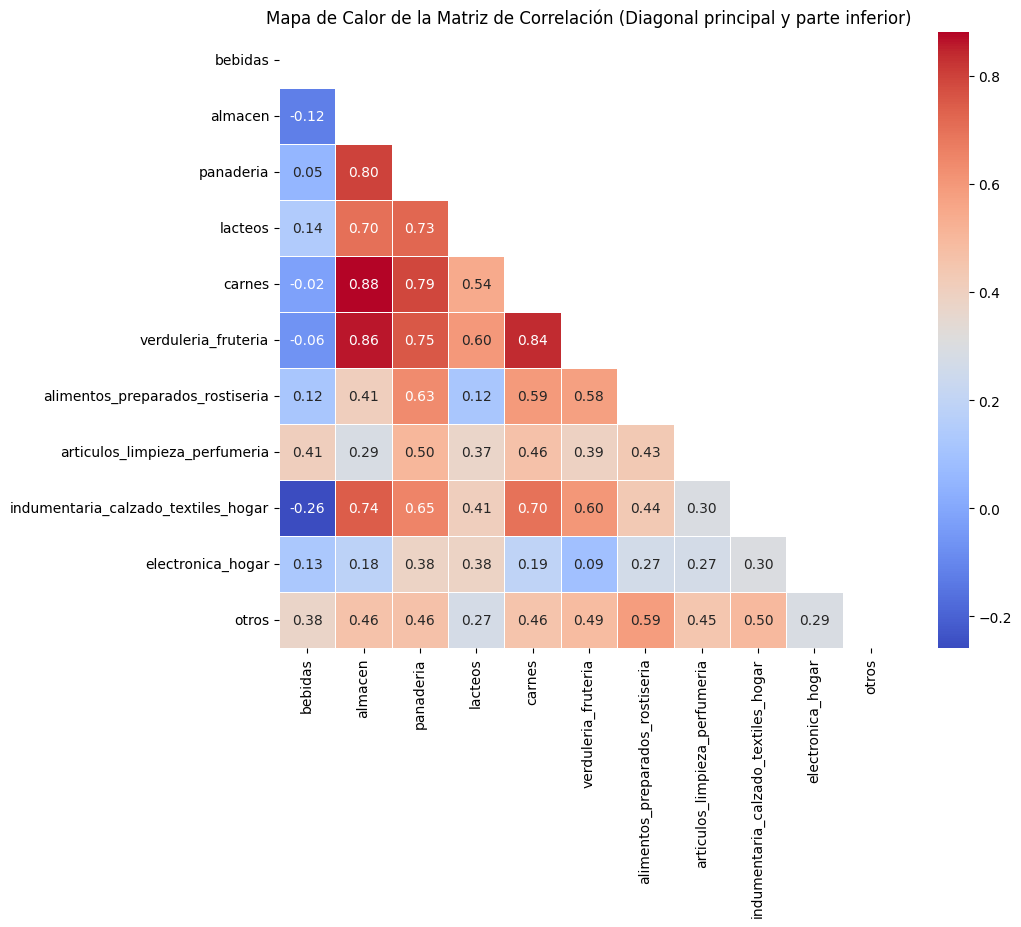

In [84]:
# Generar una máscara para ocultar la parte superior de la matriz
mask = np.triu(np.ones_like(mtz_corr, dtype=bool))

# Crear el mapa de calor con la máscara
plt.figure(figsize=(10, 8))
sns.heatmap(mtz_corr, mask=mask, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f')
plt.title('Mapa de Calor de la Matriz de Correlación (Diagonal principal y parte inferior)')
plt.show()

Creacion de una regresion lineal multiple

In [91]:
#modelo de regresion lineal
X = datos_nea[datos_nea['id_provincia_indec'] == id_base].drop(['total_facturacion','id_region_indec','id_provincia_indec','fecha'],axis=1)
Y = datos_nea['total_facturacion'][datos_nea['id_provincia_indec'] == id_base]

# Ajustar el modelo de regresión
model = sm.OLS(Y, X).fit()

# Obtener el resumen del modelo
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:      total_facturacion   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.769e+04
Date:                Wed, 19 Jun 2024   Prob (F-statistic):                   1.01e-124
Time:                        12:17:24   Log-Likelihood:                         -892.48
No. Observations:                  87   AIC:                                      1807.
Df Residuals:                      76   BIC:                                      1834.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------

Idea: probar con otros datos, no los absolutos. Probar con variaciones acumuladas talves